In [3]:
import matplotlib.pyplot as plt
import numpy as np

# generate SEM
import sys
sys.path.append("..")
from sklearn.linear_model import OrthogonalMatchingPursuit
from timeit import default_timer as timer
from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

### Generate VAR data

True W:
[[ 0.4   0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.4   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.4   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.4   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.61  0.4   0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.4   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.4   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.4   0.    0.  ]
 [ 0.    0.    0.   -0.67  0.    0.    0.    0.    0.4   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.4 ]].



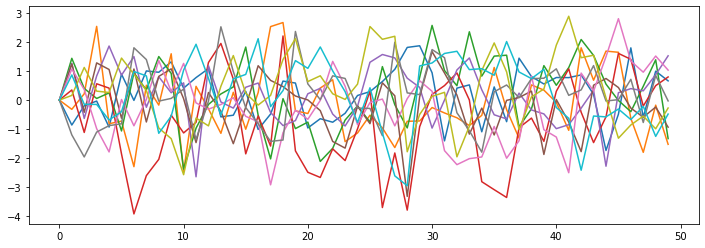

In [4]:
np.random.seed(seed = 123456)

## Number of dimensions, number of edges, number of samples
T, n, s = 50, 10, 5

N = int(n * (n + 1) / 2)

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(n, s, tril = False, low = 0.30, high = 0.70)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = 0.4 # np.abs(A_true[i][i])

s = len(A_true.flatten().nonzero()[0])

## True permutation
P_true = np.identity(n) 

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.figure(figsize = (12, 4))
plt.plot(X);

### Generate Linear Regression Data

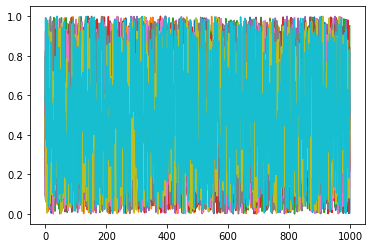

In [6]:
def normalize(X): return X / np.linalg.norm(X, 2)

# generate data
n, T = 10, 1000
w = range(n)
X = np.random.rand(T, n)
plt.plot(X)

#X_norm = X.copy()
#for i in range(n):
#    X_norm[:, i] = normalize(X_norm[:, i])

#X = X_norm.copy()
Y = X @ w #+ np.random.rand(T)

### Regular OMP

In [805]:
def OMP(X, Y):
    
    # start timer
    start = timer()
    
    # initialize Lambda, betas
    r, Lambda, Omega, betas = Y.copy(), set(), set(), np.zeros(n)
    
    # for each of the n possible coefficients
    for i in range(n):
        
        # compute gains
        gains = np.abs([r.T @ x for x in X.T])
        
        # append best atom to Lambda
        Lambda.add(np.argmax(gains))
        idx = np.array(list(Lambda))
        
        # if so, calculate new betas using only atoms in F
        Omega = X[:, idx]
        betas[idx] = np.linalg.inv(Omega.T @ Omega) @ Omega.T @ Y
        print(np.round(betas, 3))
        
        # compute new residual
        r = Y - X @ betas
    
    # end timer
    end = timer()
    
    # print result + timing
    # print(np.round(betas, 3))
    # print(f"Time taken: {round(1000 * (end - start))} milliseconds.")
    
    return betas
    
OMP(X, Y);

# KOMP(RBF_Psi, RBF_K, theta)

[-0.204  0.   ]
[-0.19  -0.057]


### Kernels

In [792]:
def RBF(i, j):
    return np.exp(-np.linalg.norm(i - j, 2) ** 2 / 2)

def L(i, j):
    return i.T @ j

In [793]:
L_Psi = np.zeros((n, n))
L_K = np.zeros(n)

for i, X_i in enumerate(X.T):
    for j, X_j in enumerate(X.T):
        L_Psi[i, j] = L(X_i, X_j)

for i, X_i in enumerate(X.T):
    L_K[i] = L(X_i, Y)
    
theta = L(Y, Y)

In [794]:
RBF_Psi = np.zeros((n, n))
RBF_K = np.zeros(n)

for i, X_i in enumerate(X.T):
    for j, X_j in enumerate(X.T):
        RBF_Psi[i, j] = RBF(X_i, X_j)

for i, X_i in enumerate(X.T):
    RBF_K[i] = RBF(X_i, Y)
    
RBF_theta = RBF(Y, Y)

In [68]:
# X_norm = np.sum(X ** 2, axis = -1)
# Psi = np.exp(-(X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)) / 2)
# print(np.shape(Psi))

# K = np.exp(-(X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)) / 2)
# print(K)

### K-OMP, Precomputed Kernels

In [798]:
def K_OMP_PRECOMP(Psi, K, theta):
    
    # start timer
    start = timer()
    
    # initialize Lambda, betas
    Lambda, betas = set(), np.zeros(n)
    
    # for each coefficient
    for i in range(n):
        
        # compute gains
        gains = [k - (betas[list(Lambda)].T @ Psi[i, list(Lambda)]) for i, k in enumerate(K)]
    
        # append best atom to Lambda
        Lambda.add(np.argmax(gains))
        idx = np.array(list(Lambda))
        
        # if so, calculate new betas using only atoms in F
        betas[idx] = np.linalg.inv(Psi[idx[:, None], idx[None, :]]) @ K[idx]
        print(np.round(betas, 2))
        
        # compute residual
        # print("Residual Squared:", round(theta - K.T @ betas, 2))
    
    # stop timer
    end = timer()
    
    # print(np.round(betas, 5))
    # print(f" {round(1000 * (end - start))} milliseconds.")
    
    return betas
    
K_OMP_PRECOMP(L_Psi, L_K, theta);

[0.   0.   2.72]
[0. 1. 2.]
[0. 1. 2.]


### K-OMP, Kernel not precomputed

In [7]:
def K_OMP(X, y):
    
    # start timer
    start = timer()
    
    # compute kernel
    Psi = X.T.dot(X)
    K = X.T.dot(y)
    theta = y.T.dot(y)
    
    # initialize Lambda, betas
    Lambda, betas = set(), np.zeros(n)
    
    # for each possible coefficient
    for i in range(n):
        
        # compute gains
        gains = np.abs([k - (betas[list(Lambda)].T @ Psi[i, list(Lambda)]) for i, k in enumerate(K)])
        
        # append best atom to Lambda
        Lambda.add(np.argmax(gains))
        idx = np.array(list(Lambda))

        # if so, calculate new betas using only atoms in F
        betas[idx] = np.linalg.inv(Psi[idx[:, None], idx[None, :]]) @ K[idx]
        print(np.round(betas, 3))
        
        # compute residuals
        # print("Residual Squared:", round(theta - K.T @ betas, 2))
    
    # stop timer
    end = timer()
    
    # print(f"{round(1000 * (end - start))}", end = "\t")
    
    return betas

K_OMP(X, Y);

[ 0.     0.     0.     0.     0.     0.    34.786  0.     0.     0.   ]
[ 0.     0.     0.     0.     0.     0.    19.017  0.     0.    21.226]
[ 0.     0.     0.     0.     0.     0.    12.889  0.    13.962 15.542]
[ 0.     0.     0.     0.     0.     0.     9.354 10.506 11.277 12.749]
[ 0.     0.     0.     0.     0.     7.058  7.959  8.684  9.753 10.989]
[0.    0.    0.    0.    4.966 5.997 7.001 7.888 8.885 9.941]
[0.    0.    0.    3.326 4.453 5.444 6.415 7.404 8.407 9.391]
[0.    0.    2.112 3.145 4.113 5.1   6.086 7.116 8.149 9.145]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


### Verifications

In [900]:
# generate data
X = h.generate_var_2(10000, np.shape(A_true)[0], A_true, P_true)

# get dimensions
T, n = np.shape(X)

# run all three methods, compare
# OMP with no kernel
OMP(X[:-1], X[1:, 0])
print()

# OMP with linear kernel
K_OMP(X[:-1], X[1:, 0])
print()

# orthogonal matching pursuit implementation of scipi
for i in range(1, n + 1):
    fit = OrthogonalMatchingPursuit(n_nonzero_coefs = i, normalize = False, fit_intercept = False)
    print(np.round(fit.fit(X[:-1], X[1:, 0]).coef_, 3))

[0.606 0.    0.    0.    0.    0.   ]
[0.457 0.    0.515 0.    0.    0.   ]
[ 0.399  0.     0.517  0.     0.    -0.496]
[ 0.397  0.     0.511  0.02   0.    -0.496]
[ 0.395 -0.014  0.511  0.019  0.    -0.493]
[ 0.395 -0.016  0.512  0.021 -0.009 -0.494]

[0.606 0.    0.    0.    0.    0.   ]
[0.457 0.    0.515 0.    0.    0.   ]
[ 0.399  0.     0.517  0.     0.    -0.496]
[ 0.397  0.     0.511  0.02   0.    -0.496]
[ 0.395 -0.014  0.511  0.019  0.    -0.493]
[ 0.395 -0.016  0.512  0.021 -0.009 -0.494]

[0.606 0.    0.    0.    0.    0.   ]
[0.457 0.    0.515 0.    0.    0.   ]
[ 0.399  0.     0.517  0.     0.    -0.496]
[ 0.397  0.     0.511  0.02   0.    -0.496]
[ 0.395 -0.014  0.511  0.019  0.    -0.493]
[ 0.395 -0.016  0.512  0.021 -0.009 -0.494]


### Matrix K-OMP, Kernel not precomputed

In [841]:
def MATRIX_KOMP(X, Y, verbose = False):

    start = timer()
    
    # intialize F
    F = np.full((n, n), False)
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    Theta = [y.T.dot(y) for y in Y.T]
    
    # initialize Lambda, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([k - betas.T @ Psi[i, :] for i, k in enumerate(K)])
        
        # append best atom to Lambda
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
        
        # update only column col, use indices of 
        idx = Lambda[col]
        Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
        # update betas        
        betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
    
        # compute residual
        # print(f"Residual Squared: {np.round([Theta[i] - K.T[i, :] @ betas[:, i] for i in range(n)])}.\n\n")
    
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 1)}.\n")
            
    end = timer()
    
    print(f"{round(1000 * (end - start))}", end = "\t")
    
    return betas

# generate data
MATRIX_KOMP(X[:-1], X[1:]);

11	

In [846]:
# get X large
X_large = np.kron(np.eye(n, dtype=float), X[:-1])

# Stack all X on top of each other for y
y_large = X[1:].T.reshape((T - 1) * n, 1)
    
for i in range(1, n ** 2 + 1):
    fit = OrthogonalMatchingPursuit(n_nonzero_coefs = i, fit_intercept = False, normalize = True)
    # print(np.round(fit.fit(X_large, y_large).coef_.reshape(n, n).T, 1))

### DAG-K-OMP

In [912]:
def Lambda_to_adj(Lambda):
    n = len(Lambda)
    
    adj_mat = np.zeros((n, n))
    
    for i, col in enumerate(Lambda):
        adj_mat[i, col] = 1 
    
    return adj_mat

Lambda_to_adj(L)

IndexError: arrays used as indices must be of integer (or boolean) type

In [910]:
def DAG_KOMP(X, Y, verbose = False):

    start = timer()
    
    # intialize F, forbidden set
    F = []
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    Theta = [y.T.dot(y) for y in Y.T]
    
    # initialize Lambda, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([k - betas.T @ Psi[i, :] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick
        gains = gains.flatten()
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
        
        # append best atom to Lambda
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # update betas        
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
    
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K.T[i, :] @ betas[:, i] for i in range(n)])}.\n\n")
            
    end = timer()
    
    print(f"{round(1000 * (end - start))}", end = "\t")
    
    return betas

# generate data
W_KOMP = DAG_KOMP(X[:-1], X[1:], verbose = False);

3101	

In [911]:
start = timer()
W_OMP = m._OMP_2(X[:-1], X[1:])
print(round(1000 * (timer() - start)))

2841826
